In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

<ipython-input-1-fcfec4638be8>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
warnings.filterwarnings(action='ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def map_vis(df, target: str):
    fig = px.scatter_mapbox(df,
                        lat = "lat",
                        lon = "lon",
                        color = target,
                        size = target,
                        color_continuous_scale = px.colors.cyclical.IceFire,
                        size_max = 25, zoom = 10,
                        mapbox_style = "carto-positron",
                        width=1000, height=600)
    fig.show()

def corr_vis(df):
    fig = plt.figure(figsize = (10, 5))
    dataplot = sns.heatmap(df.corr(method='spearman'), cmap="YlGnBu", annot=True)

    plt.show()

def distrib_plot(data, target: str):
    sns.displot(data, x=target)

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/MLID/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/MLID/validation_data.csv')

In [ ]:
train_data.head(3)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...


In [ ]:
validation_data.head(3)

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735


# Data Preprocessing

In [ ]:
# Train data preprocessing
train_data_filtered = train_data[
    (train_data['lon'] > 30.142969) &
    (train_data['lon'] < 30.515771) &
    (train_data['lat'] > 59.831191) &
    (train_data['lat'] < 60.039332)
]
train_data_filtered['date'] = pd.to_datetime(train_data['timestamp'], unit='s')
train_data_filtered.head(3)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,date
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,2019-08-12 11:00:00
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,2019-08-12 00:00:00
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,2019-08-12 00:00:00


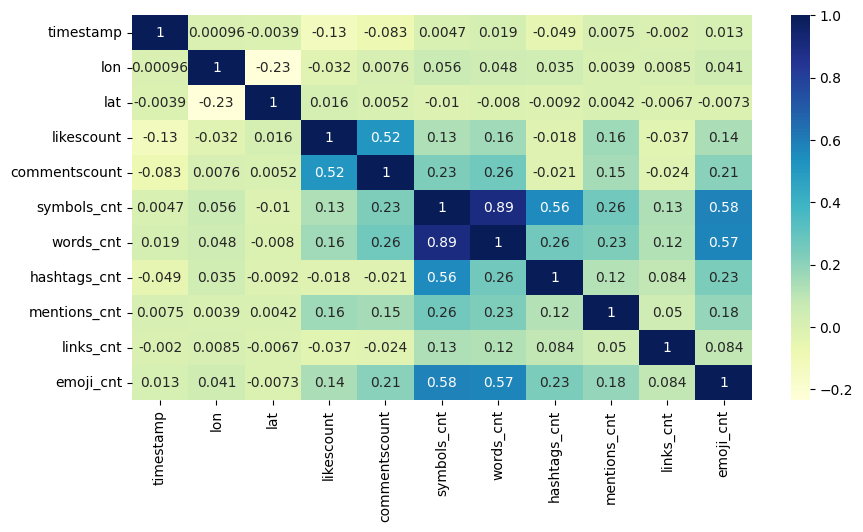

In [ ]:
# correlation heatmap for train dataset after filtering by lon and lat
corr_vis(train_data_filtered)

In [ ]:
# Validation data preprocessing
validation_data_filtered = validation_data[
    (validation_data['lon'] > 30.142969) &
    (validation_data['lon'] < 30.515771) &
    (validation_data['lat'] > 59.831191) &
    (validation_data['lat'] < 60.039332)
]
validation_data_filtered['date'] = pd.to_datetime(validation_data['hour'], unit='s')
validation_data_filtered.head(3)

,hour,lat,lon,point,sum,error,date
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402,2020-02-23 09:00:00
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291,2020-02-20 19:00:00
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735,2020-02-09 15:00:00


In [ ]:
train_loc_points = train_data_filtered['point'].unique()
valid_loc_points = validation_data_filtered['point'].unique()

common_point_list = [point for point in train_loc_points if point in valid_loc_points]

print(f"Unique points in train: {len(train_loc_points)}")
print(f"Unique points in valid: {len(valid_loc_points)}")
print(f"Points of intersection between valid & train data: {len(common_point_list)}")

Unique points in train: 6658
Unique points in valid: 151
Points of intersection between valid & train data: 151


In [ ]:
train_data_grouped = train_data_filtered \
  .groupby(['point','date']) \
  .size() \
  .reset_index() \
  .rename(columns={0: 'n_posts'})

train_data_grouped.head()

,point,date,n_posts
0,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 16:00:00,1
1,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-02 12:00:00,1
2,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-02 13:00:00,1
3,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-08 16:00:00,1
4,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-12 11:00:00,1


In [ ]:
# Validation data processing (grouping)
validation_data_grouped = validation_data_filtered \
  .groupby(['point','date'])['sum'] \
  .sum() \
  .reset_index() \
  .rename(columns={'sum': 'n_posts'})

validation_data_grouped.head()

,point,date,n_posts
0,0101000020E61000000C830D47F15C3E400A41C338F1F6...,2020-02-19 11:00:00,6
1,0101000020E61000000C830D47F15C3E400A41C338F1F6...,2020-02-26 07:00:00,8
2,0101000020E61000000C830D47F15C3E40CAE971F73AF7...,2020-02-04 17:00:00,9
3,0101000020E61000000C830D47F15C3E40CAE971F73AF7...,2020-02-06 16:00:00,7
4,0101000020E61000000C830D47F15C3E40CAE971F73AF7...,2020-02-11 11:00:00,11


In [ ]:
train_data_grouped_for_vis = train_data_filtered \
  .groupby(['point','lat', 'lon']) \
  .size() \
  .reset_index() \
  .rename(columns={0: 'total_num_post_all_time'})

train_data_grouped_for_vis.head(15)

,point,lat,lon,total_num_post_all_time
0,0101000020E610000002BF48199F3F3E400A41C338F1F6...,59.929237,30.248521,9
1,0101000020E610000002BF48199F3F3E400A721DB144FC...,59.970846,30.248521,226
2,0101000020E610000002BF48199F3F3E400B9A5B330603...,60.023627,30.248521,61
3,0101000020E610000002BF48199F3F3E400C44B6B2C5F3...,59.904471,30.248521,72
4,0101000020E610000002BF48199F3F3E4010C569574E02...,60.018016,30.248521,4587
5,0101000020E610000002BF48199F3F3E4014A96F5908F1...,59.883067,30.248521,1
6,0101000020E610000002BF48199F3F3E4015DC4D3BBB01...,60.013526,30.248521,325
7,0101000020E610000002BF48199F3F3E401FBF4913EFF5...,59.921359,30.248521,5
8,0101000020E610000002BF48199F3F3E4021096A9925EE...,59.860522,30.248521,173
9,0101000020E610000002BF48199F3F3E402265734F2C04...,60.032602,30.248521,38


In [ ]:
map_vis(train_data_grouped_for_vis, 'total_num_post_all_time')

In [ ]:
train_data_grouped_for_vis = train_data_grouped_for_vis[train_data_grouped_for_vis['point'].isin(common_point_list)]
len(train_data_grouped_for_vis)

151

In [ ]:
map_vis(train_data_grouped_for_vis, 'total_num_post_all_time')

In [ ]:
train_data_grouped = train_data_grouped[train_data_grouped['point'].isin(common_point_list)]
len(train_data_grouped)

873082

In [ ]:
min_date = min(train_data_grouped['date'])
max_date = max(train_data_grouped['date'])

dates_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='h').to_list()})

In [ ]:
train_data_grouped_list = [
    train_data_grouped[(train_data_grouped['point'] == point) & (train_data_grouped['point'].isin(common_point_list))] \
      .merge(dates_range, on='date', how='outer') \
      .sort_values(by='date') \
      .reset_index(drop=True) \
      .drop(columns='point') \
      .fillna(0)

    for point in sorted(train_data_grouped['point'].unique())
]

train_data_grouped_list[0]

,date,n_posts
0,2019-01-01 00:00:00,2.0
1,2019-01-01 01:00:00,0.0
2,2019-01-01 02:00:00,0.0
3,2019-01-01 03:00:00,0.0
4,2019-01-01 04:00:00,0.0
...,...,...
9499,2020-01-31 19:00:00,3.0
9500,2020-01-31 20:00:00,7.0
9501,2020-01-31 21:00:00,5.0
9502,2020-01-31 22:00:00,3.0


In [ ]:
min_date_val = min(validation_data_grouped['date'])
max_date_val = max(validation_data_grouped['date'])

dates_range_for_val = pd.DataFrame({'date': pd.date_range(min_date_val, max_date_val, freq='h').to_list()})

validation_data_grouped_list = [
    validation_data_grouped[validation_data_grouped['point'] == point] \
      .merge(dates_range_for_val, on='date', how='outer') \
      .sort_values(by='date') \
      .reset_index(drop=True) \
      .drop(columns='point') \
      .fillna(0)

    for point in sorted(validation_data_grouped['point'].unique())
]

# Model Initialization

In [ ]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;

    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.25,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#  inverse_difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [ ]:
n_lag = 12
n_seq = 24 * 28
n_test = 2
n_epochs = 2
n_batch = 1
n_neurons =  12

In [ ]:
def get_forecast(data, i):
    ex_data = data[i]['n_posts']

    scaler, train, test = prepare_data(ex_data, n_test, n_lag, n_seq)
    model, history_loss, history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

    forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
    forecasts = inverse_transform(ex_data, forecasts, scaler, n_test+2)

    return ex_data, forecasts

def get_graph(data, i):
    ex_data, forecast = get_forecast(data, i)

    figure = plt.figure(figsize = (20, 6))
    lstm_forecasts = ([np.nan] * (len(ex_data) - len(forecast[-1]))) + forecast[-1]
    n_2_show = len(ex_data) - len(forecast[-1]) - 50

    plt.plot(ex_data[n_2_show:])
    plt.plot(lstm_forecasts, color='g')

    plt.title(f'Test/Pred comparison for point {i}')
    plt.xlabel("")
    plt.ylabel('N posts')

In [ ]:
array_aa = list()

for i in range(len(train_data_grouped_list)):
    array_aa.append({
        'point': i,
        'n_posts': sum(train_data_grouped_list[i]['n_posts'])
    })

pd.DataFrame(array_aa).sort_values('n_posts', ascending=False)

,point,n_posts
59,59,196054.0
116,116,145191.0
24,24,118465.0
53,53,115011.0
80,80,104442.0
...,...,...
63,63,3285.0
122,122,3035.0
146,146,2837.0
94,94,1877.0


0
6613/6613 [==============================] - 32s 5ms/step - loss: 0.0291 - val_loss: 0.0231
1
6613/6613 [==============================] - 28s 4ms/step - loss: 0.0289 - val_loss: 0.0230
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_154 (LSTM)             (1, 12)                   1200      
                                                                 
 dense_154 (Dense)           (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 17ms/step


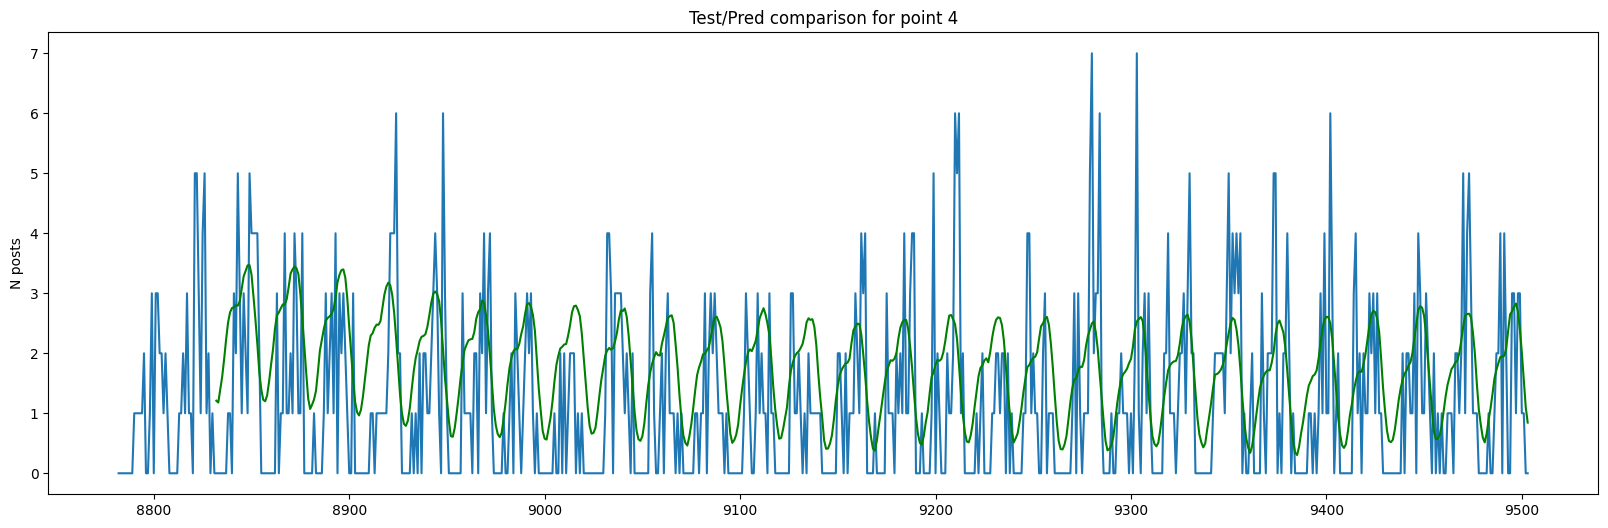

In [ ]:
get_graph(train_data_grouped_list, 4)

0
6613/6613 [==============================] - 30s 4ms/step - loss: 0.0107 - val_loss: 0.0166
1
6613/6613 [==============================] - 26s 4ms/step - loss: 0.0107 - val_loss: 0.0165
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 12)                   1200      
                                                                 
 dense_1 (Dense)             (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 26ms/step


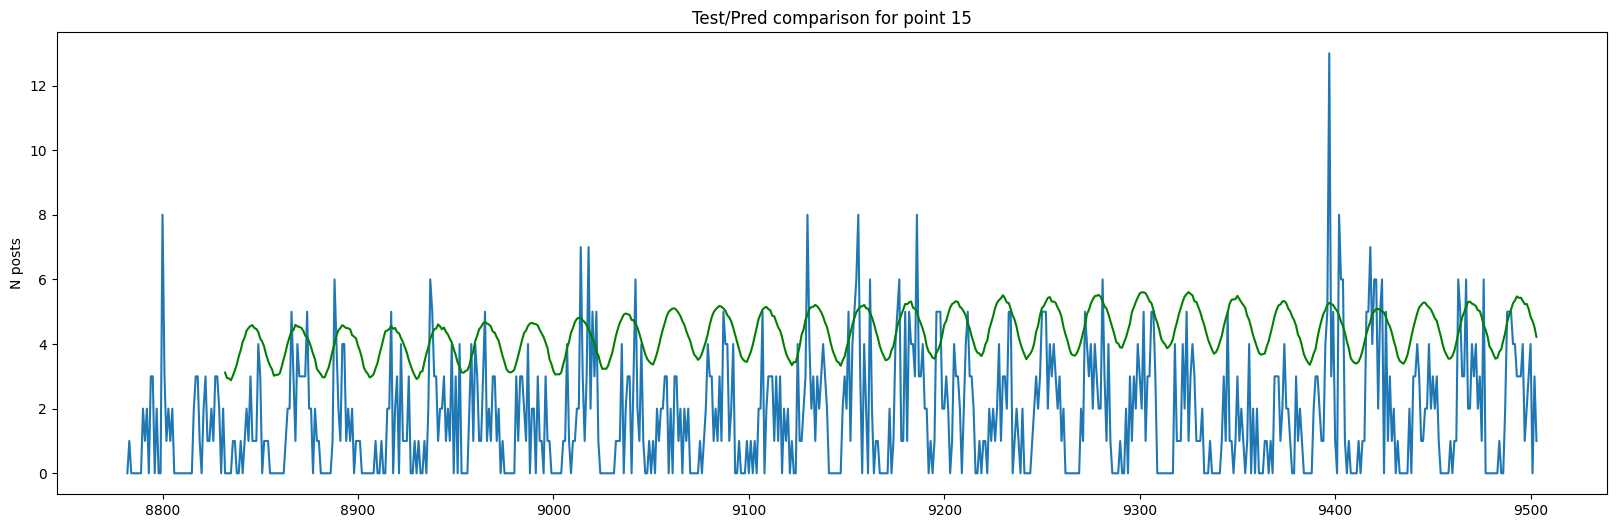

In [ ]:
get_graph(train_data_grouped_list, 15)

0
6613/6613 [==============================] - 30s 4ms/step - loss: 0.0048 - val_loss: 0.0118
1
6613/6613 [==============================] - 28s 4ms/step - loss: 0.0048 - val_loss: 0.0118
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_159 (LSTM)             (1, 12)                   1200      
                                                                 
 dense_159 (Dense)           (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 16ms/step


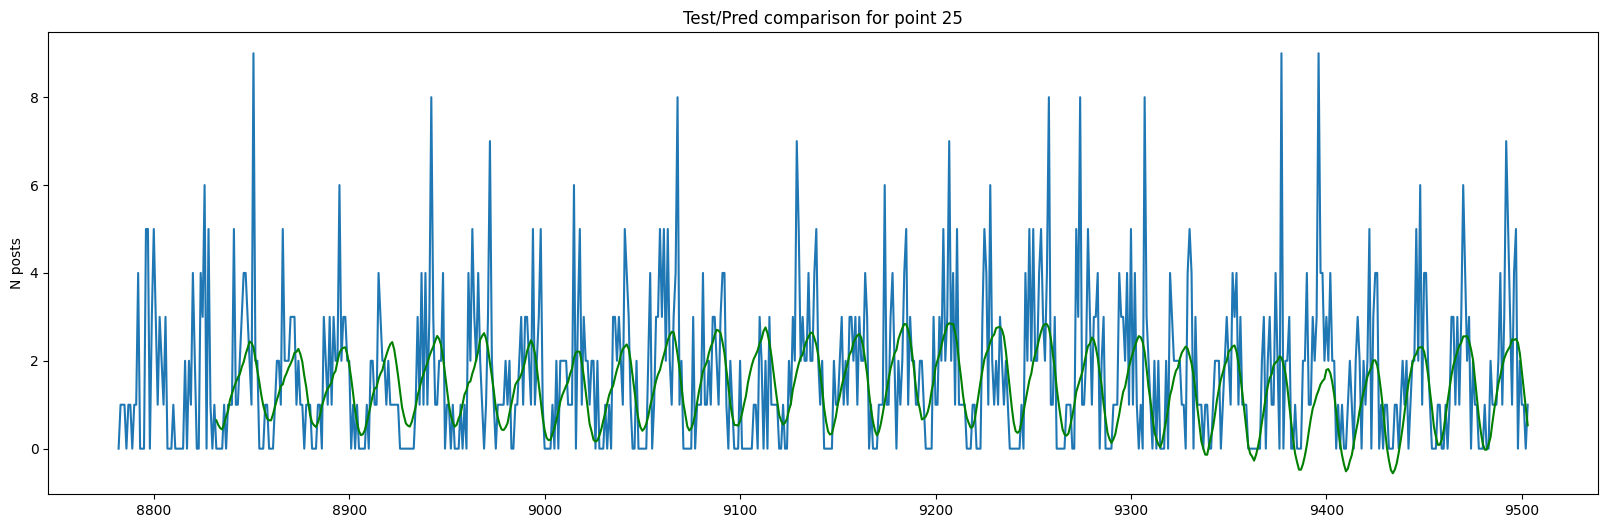

In [ ]:
get_graph(train_data_grouped_list, 25)

In [ ]:
forecast_list = []
error_list = []

for i in range(len(train_data_grouped_list)):
    ex_data, forecasts = get_forecast(train_data_grouped_list, i)
    ex_data_val = validation_data_grouped_list[i]['n_posts']

    forecast_list.append(pd.DataFrame({
        'fact': ex_data_val[(len(ex_data_val) - len(forecasts[-1])):],
        'pred': forecasts[-1]
    }))

0
6613/6613 [==============================] - 29s 4ms/step - loss: 0.0164 - val_loss: 0.0141
1
6613/6613 [==============================] - 27s 4ms/step - loss: 0.0163 - val_loss: 0.0141
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 12)                   1200      
                                                                 
 dense_2 (Dense)             (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 16ms/step
0
6613/6613 [==============================] - 29s 4ms/step - loss: 0.0059 - val_loss: 0.0241
1
6613/6613 [==============================] - 26s 4ms/step - loss: 0.0059 - 

1/1 [==============================] - 0s 24ms/step
0
6613/6613 [==============================] - 30s 4ms/step - loss: 0.0084 - val_loss: 0.0209
1
6613/6613 [==============================] - 27s 4ms/step - loss: 0.0083 - val_loss: 0.0207
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (1, 12)                   1200      
                                                                 
 dense_5 (Dense)             (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


1/1 [==============================] - 0s 16ms/step
0
6613/6613 [==============================] - 31s 4ms/step - loss: 0.0291 - val_loss: 0.0231
1
6613/6613 [==============================] - 26s 4ms/step - loss: 0.0289 - val_loss: 0.0231
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 12)                   1200      
                                                                 
 dense_6 (Dense)             (1, 672)                  8736      
                                                                 
Total params: 9936 (38.81 KB)
Trainable params: 9936 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 18ms/step
0
6613/6613 [==============================] - 29s 4ms/step - loss: 0.0147 - val_loss: 0.0289
1
6613/6613 [============

In [ ]:
errors_list = [i.assign(error = lambda df: abs((df['pred'] - df['fact']) / df['pred']))['error'].mean() for i in forecast_list]
pd.Series(errors_list).describe()

count    151.000000
mean       1.006504
std        0.027963
min        0.985524
25%        0.997268
50%        0.999497
75%        1.003614
max        1.195492
dtype: float64

In [ ]:
px.histogram(pd.DataFrame({'error': errors_list}), x='error', width=700, height=600)